# Prognosx


Exploratory Data Analysis

In [562]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import arff

Downloading the data from the UCI ML Repository resulted in a .arff file (?), however someone had already converted this data into .csv in Kaggle.
I decided to use the kaggle data due to convenience. I also did check for any discrepencies.
https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io/66939746#66939746

In [563]:
df = pd.read_csv("kidney_disease.csv")
df

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [564]:
df.shape

(400, 26)

In [565]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [566]:
# pcv, wc, and rc are actually numerical. 
df['pcv'] = pd.to_numeric(df['pcv'], errors='coerce')
df['wc'] = pd.to_numeric(df['wc'], errors='coerce')
df['rc'] = pd.to_numeric(df['rc'], errors='coerce')

# sg, al, su are categorical
categorical_cols = ['sg', 'al', 'su']
df[categorical_cols] = df[categorical_cols].astype('object')

In [567]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    object 
 4   al              354 non-null    object 
 5   su              351 non-null    object 
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             329 non-null    float64
 17  wc              294 non-null    flo

In [568]:
# Checking for duplicated data
df.duplicated().sum()

np.int64(0)

In [569]:
# unique values per feature
df.nunique()

id                400
age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  5
cad                 3
appet               2
pe                  2
ane                 2
classification      3
dtype: int64

I noticed that data that should only have 2 unique values has more than 2 such as cad, classification, and dm. Upon further inspection in the .csv file, there are trailing spaces in some rows. So, below I remove those spaces:

In [570]:
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [571]:
df.nunique()

id                400
age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  2
cad                 2
appet               2
pe                  2
ane                 2
classification      2
dtype: int64

Below shows how many values are missing per column. I noticed that a lot of rows were missing information about red blood cells (rbc), red blood cell count (rc), and white blood cell count (wc)...

In [572]:
# Percentage of missing data/rows per feature
df.isnull().sum() / df.shape[0] * 100

id                 0.00
age                2.25
bp                 3.00
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.00
pcv               17.75
wc                26.50
rc                32.75
htn                0.50
dm                 0.50
cad                0.50
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

rbc
normal      201
abnormal     47
Name: count, dtype: int64

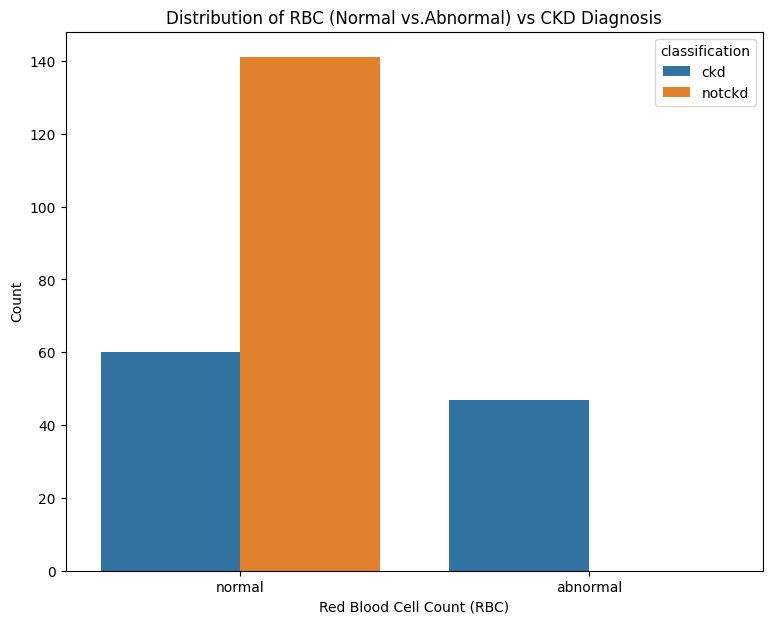

In [573]:
sns.countplot(data=df, x='rbc', hue='classification')
plt.title('Distribution of RBC (Normal vs.Abnormal) vs CKD Diagnosis')
plt.xlabel('Red Blood Cell Count (RBC)')
plt.ylabel('Count')
df['rbc'].value_counts()

So, we do not have any data for when it is notckd and it is abnormal. Maybe it is a strong indicator of rbc being abnormal showing that it is ckd.

rbc
normal      353
abnormal     47
Name: count, dtype: int64

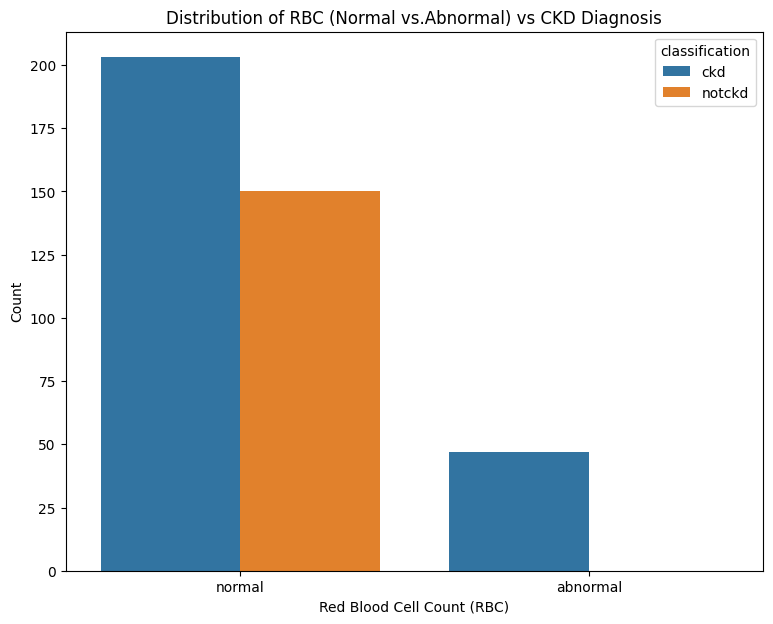

In [574]:
# imputation - replacing missing values for categorical data using the mode for RBC
df['rbc'] = df['rbc'].fillna(df['rbc'].mode()[0])

sns.countplot(data=imp_rbc_df, x='rbc', hue='classification')
plt.title('Distribution of RBC (Normal vs.Abnormal) vs CKD Diagnosis')
plt.xlabel('Red Blood Cell Count (RBC)')
plt.ylabel('Count')
imp_rbc_df['rbc'].value_counts()

A lot of people missing the RBC feature are diagnosed with ckd... I think maybe we should discard the rbc feature?

In [575]:
# droppping the id feature
df = df.drop('id', axis=1)

# spiltting cols into numerical and catergorical for later analysis?
numerical_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
df_numeric = df[numerical_cols]

categorical_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
df_categorical = df[categorical_cols]

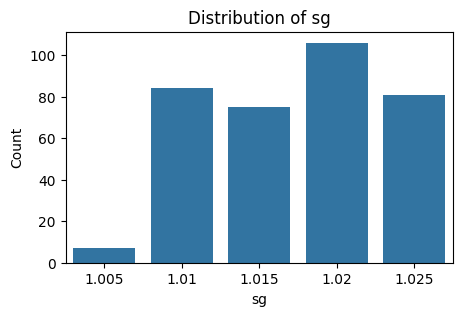

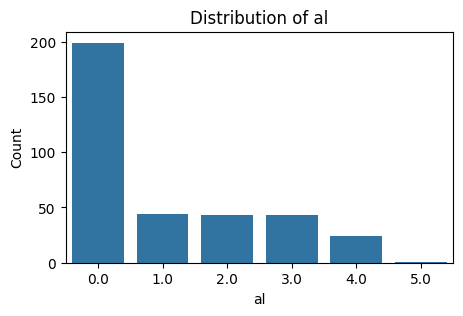

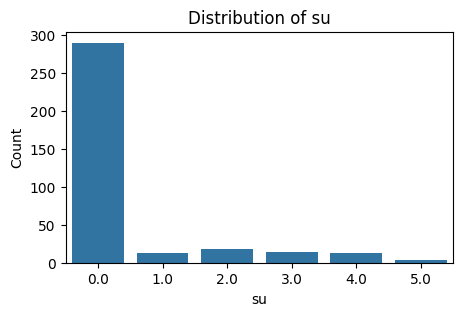

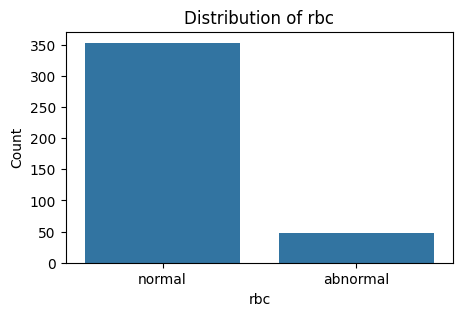

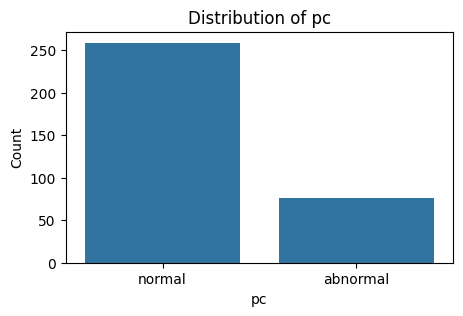

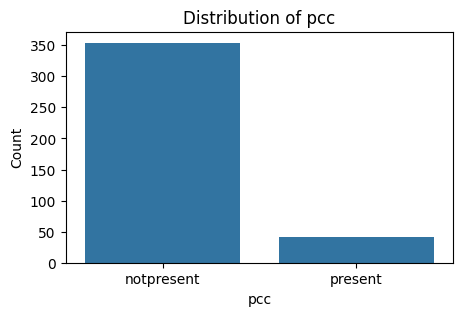

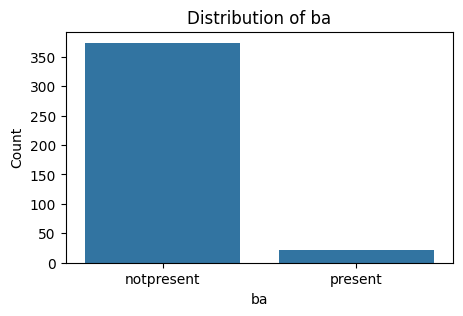

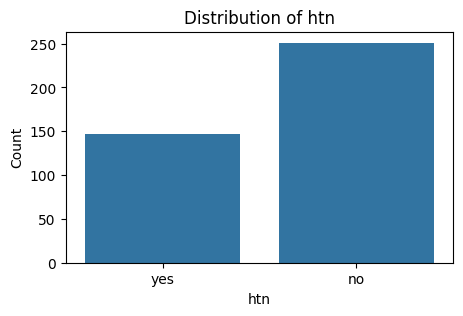

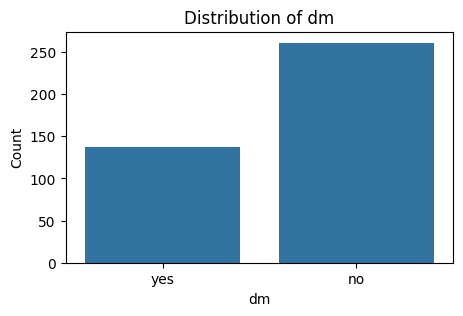

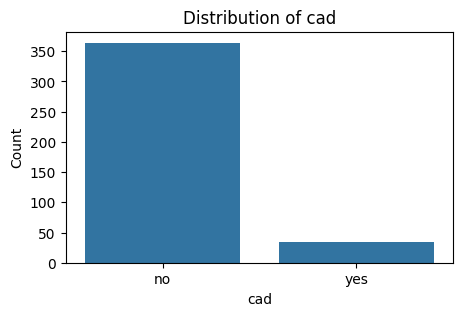

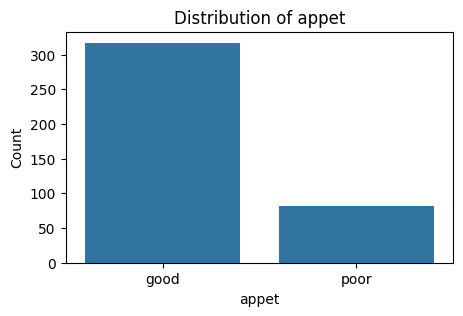

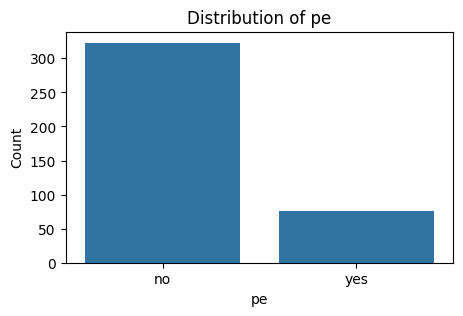

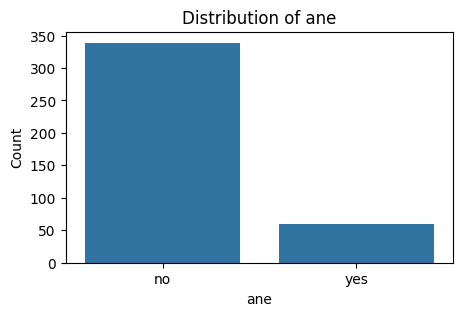

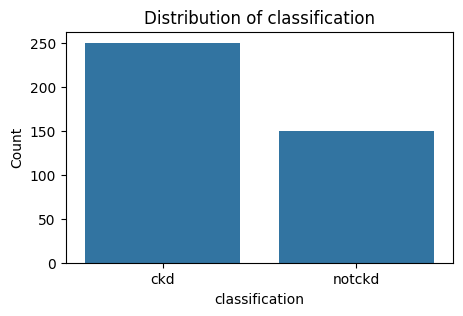

In [576]:
#  distribution of categorical data 
for col in categorical_cols:
    plt.figure(figsize=(5, 3)) 
    sns.countplot(x=df[col], data=df) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.show()

In [577]:
# mode imputation on categorical data
df['sg'] = df['sg'].fillna(df['sg'].mode()[0])
df['al'] = df['al'].fillna(df['al'].mode()[0])
df['su'] = df['su'].fillna(df['su'].mode()[0])
df['pc'] = df['pc'].fillna(df['pc'].mode()[0])
df['pcc'] = df['pcc'].fillna(df['pcc'].mode()[0])
df['ba'] = df['ba'].fillna(df['ba'].mode()[0])
df['htn'] = df['htn'].fillna(df['htn'].mode()[0])
df['cad'] = df['cad'].fillna(df['cad'].mode()[0])
df['appet'] = df['appet'].fillna(df['appet'].mode()[0])
df['htn'] = df['htn'].fillna(df['htn'].mode()[0])
df['cad'] = df['cad'].fillna(df['cad'].mode()[0])
df['dm'] = df['dm'].fillna(df['dm'].mode()[0])
df['appet'] = df['appet'].fillna(df['appet'].mode()[0])
df['pe'] = df['pe'].fillna(df['pe'].mode()[0])
df['ane'] = df['ane'].fillna(df['ane'].mode()[0])

In [578]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             400 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

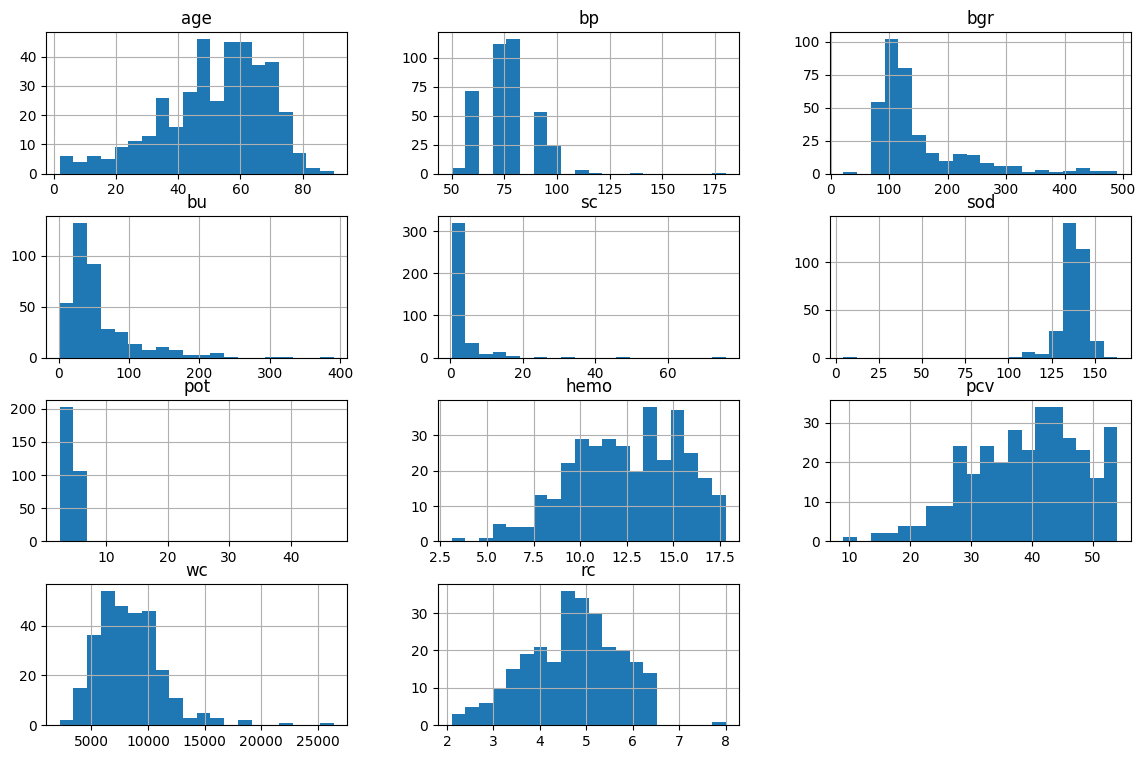

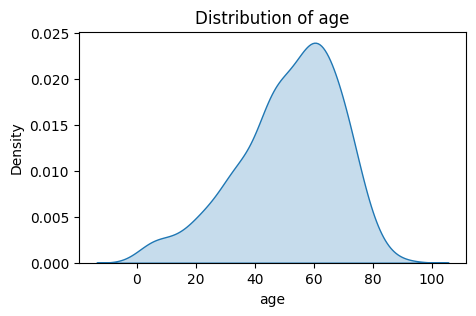

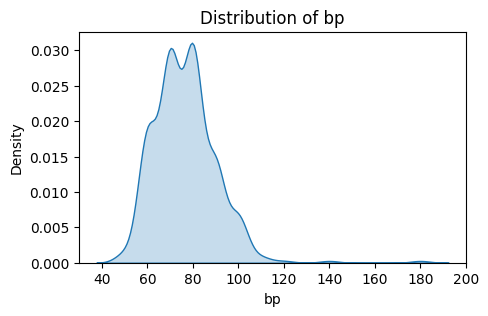

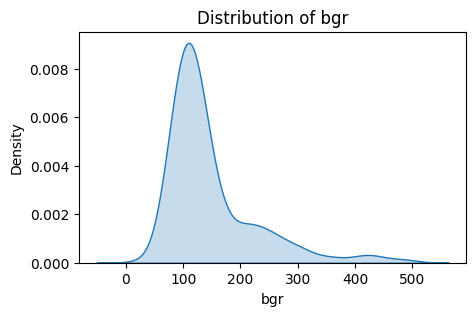

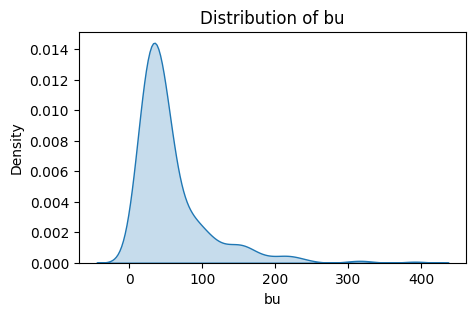

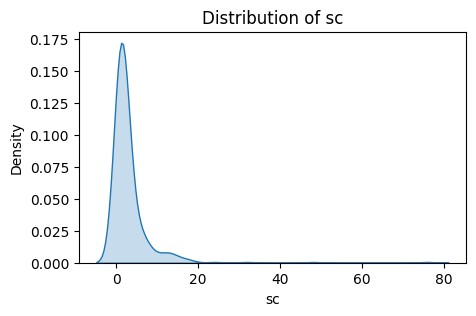

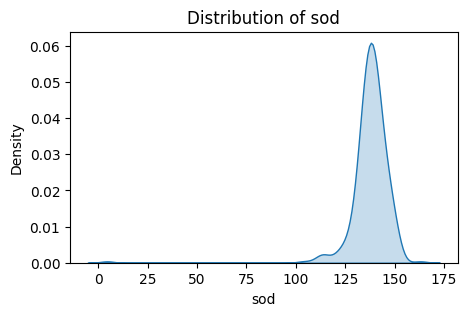

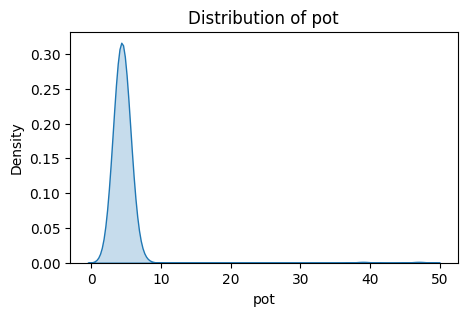

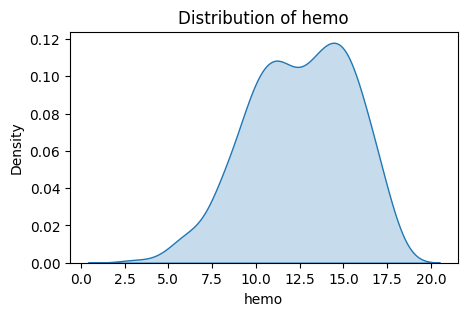

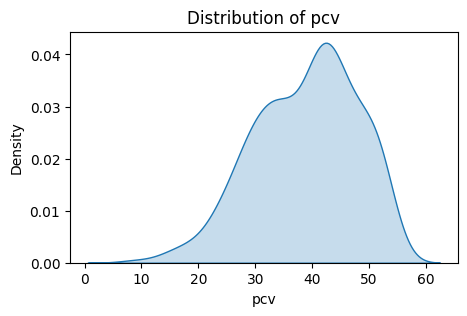

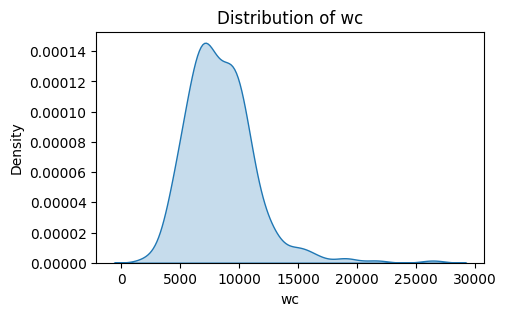

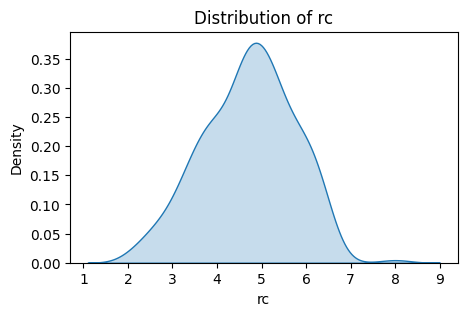

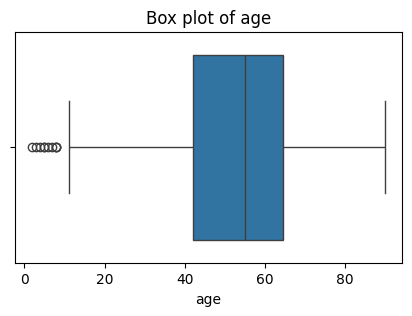

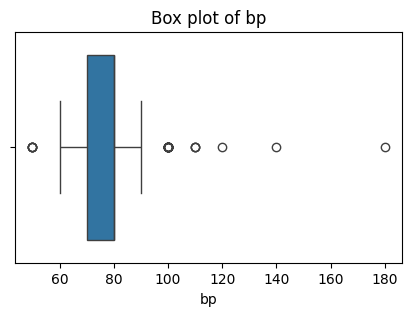

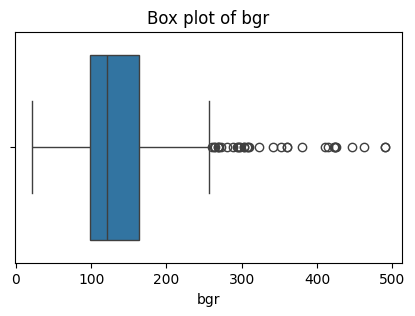

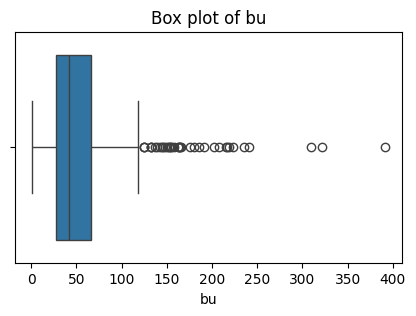

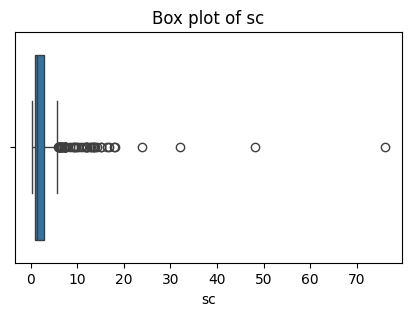

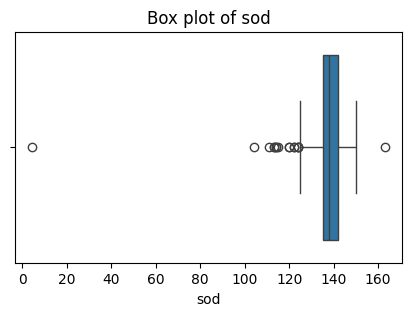

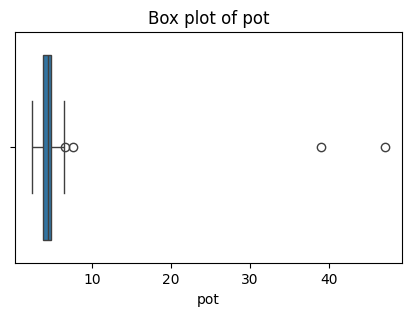

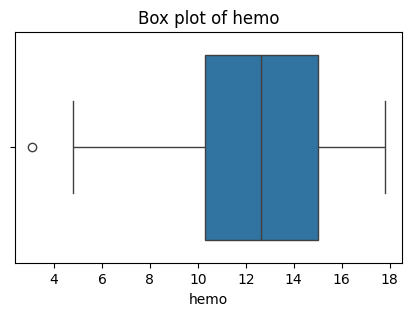

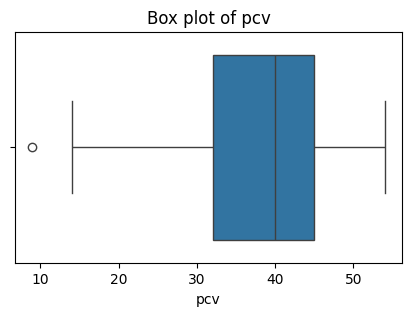

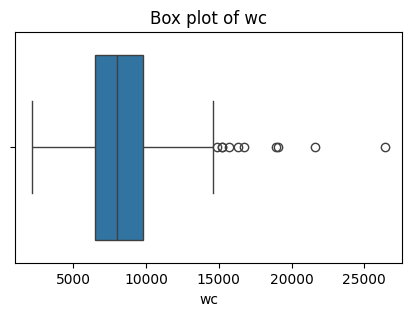

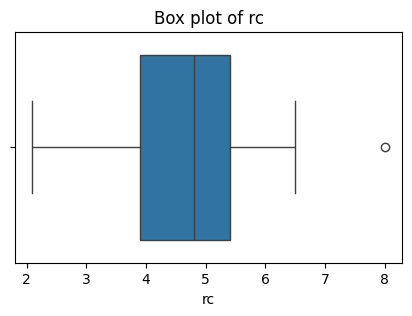

In [579]:
# numerical feature distributions

# histograms
df[numerical_cols].hist(bins=20, figsize=(14, 9))
plt.show()

# KDE
for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box for visible outliers
for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

In [580]:
skewness = df[numerical_cols].skew()
print(skewness)

age     -0.668259
bp       1.605429
bgr      2.010773
bu       2.634374
sc       7.509538
sod     -6.996569
pot     11.582956
hemo    -0.335095
pcv     -0.433679
wc       1.621589
rc      -0.183329
dtype: float64


In [581]:
# imputation on numerical data either mean/median depending on outliers
#  impute w mean when almost symmetric data, impute w median when skewed data
#  im not sure if this is the right approach either.. i have a feeling it's not...
# also, i think if someone is reading this, 
# I woudl like to drop any data that has more than 70% feature info missing, like #31 in the csv
df['age'] = df['age'].fillna(df['age'].median())
df['bp'] = df['bp'].fillna(df['bp'].median())
df['bgr'] = df['bgr'].fillna(df['bgr'].median())
df['bu'] = df['bu'].fillna(df['bu'].median())
df['sc'] = df['sc'].fillna(df['sc'].median())
df['sod'] = df['sod'].fillna(df['sod'].median())
df['pot'] = df['pot'].fillna(df['pot'].median())
df['hemo'] = df['hemo'].fillna(df['hemo'].median())
df['pcv'] = df['pcv'].fillna(df['pcv'].median())
df['wc'] = df['wc'].fillna(df['wc'].median())
df['rc'] = df['rc'].fillna(df['rc'].mean())  

In [582]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,1.017712,0.90000,0.395000,145.062500,56.693000,2.997125,137.631250,4.577250,12.54250,39.082500,8298.500000,4.707435
std,16.982996,13.489785,0.005434,1.31313,1.040038,75.260774,49.395258,5.628886,9.206332,2.821357,2.71649,8.162245,2529.593814,0.840314
min,2.000000,50.000000,1.005000,0.00000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.10000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.015000,0.00000,0.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.87500,34.000000,6975.000000,4.500000
50%,55.000000,80.000000,1.020000,0.00000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.65000,40.000000,8000.000000,4.707435
75%,64.000000,80.000000,1.020000,2.00000,0.000000,150.000000,61.750000,2.725000,141.000000,4.800000,14.62500,44.000000,9400.000000,5.100000
max,90.000000,180.000000,1.025000,5.00000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.80000,54.000000,26400.000000,8.000000


In [583]:
df.describe(include='object')

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,classification
count,400,400,400,400,400,400,400,400,400,400,400
unique,2,2,2,2,2,2,2,2,2,2,2
top,normal,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
freq,353,324,358,378,253,263,366,318,324,340,250


In [584]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             400 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             400 non-null    float64
 10  bu              400 non-null    float64
 11  sc              400 non-null    float64
 12  sod             400 non-null    float64
 13  pot             400 non-null    float64
 14  hemo            400 non-null    float64
 15  pcv             400 non-null    float64
 16  wc              400 non-null    float64
 17  rc              400 non-null    flo

In [585]:
df_numeric.corr()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
age,1.000000,0.159480,0.244992,0.196985,0.132531,-0.100046,0.058377,-0.192928,-0.242119,0.118339,-0.268896
bp,0.159480,1.000000,0.160193,0.188517,0.146222,-0.116422,0.075151,-0.306540,-0.326319,0.029753,-0.261936
bgr,0.244992,0.160193,1.000000,0.143322,0.114875,-0.267848,0.066966,-0.306189,-0.301385,0.150015,-0.281541
bu,0.196985,0.188517,0.143322,1.000000,0.586368,-0.323054,0.357049,-0.610360,-0.607621,0.050462,-0.579087
sc,0.132531,0.146222,0.114875,0.586368,1.000000,-0.690158,0.326107,-0.401670,-0.404193,-0.006390,-0.400852
sod,-0.100046,-0.116422,-0.267848,-0.323054,-0.690158,1.000000,0.097887,0.365183,0.376914,0.007277,0.344873
pot,0.058377,0.075151,0.066966,0.357049,0.326107,0.097887,1.000000,-0.133746,-0.163182,-0.105576,-0.158309
hemo,-0.192928,-0.306540,-0.306189,-0.610360,-0.401670,0.365183,-0.133746,1.000000,0.895382,-0.169413,0.798880
pcv,-0.242119,-0.326319,-0.301385,-0.607621,-0.404193,0.376914,-0.163182,0.895382,1.000000,-0.197022,0.791625
wc,0.118339,0.029753,0.150015,0.050462,-0.006390,0.007277,-0.105576,-0.169413,-0.197022,1.000000,-0.158163


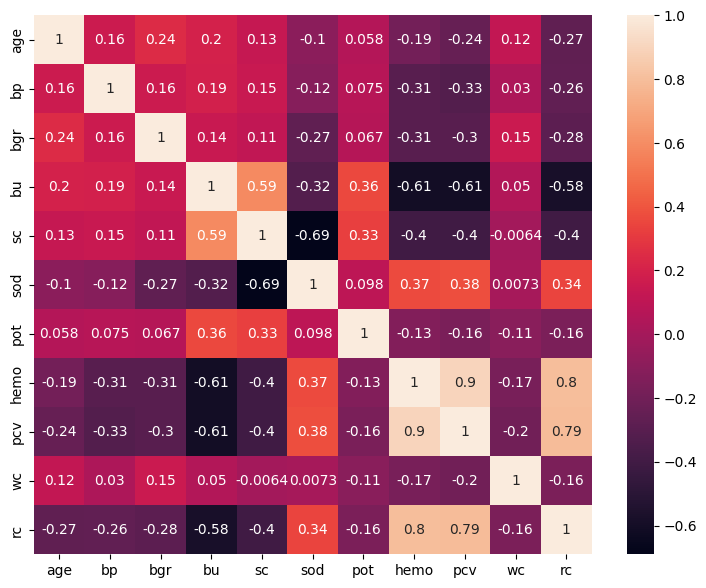

In [586]:
sns.heatmap(df_numeric.corr(), annot=True)
plt.show()

In [ ]:
sns.pairplot(df[numerical_cols + ['classification']], hue='classification')
plt.show()